# Libraries

In [32]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

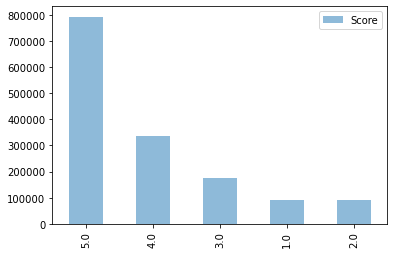


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Loading Files for Test

In [21]:
testingSet = testingSet.merge(trainingSet, on='Id', how='left').drop(columns=["Score_x", "Score_y"])
testingSet.head()


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text
0,1323432,B0034G4P30,A120UTHQDQIJGH,0,0,1391040000,Okay for a rental,This movie was just alright for me. I think pe...
1,1137299,B0012IWO0I,A3SJBFCTJWBFT2,1,1,1388188800,Great for kids,My kids love this movie. Exciting and fun to ...
2,1459366,B005FUTBSC,A1V6FRU7EXP6N9,0,0,1356739200,good movie,"The effects were good, not the best but far fr..."
3,931601,B000AREXBU,ARXDDR76Z5Q2I,5,5,1169510400,Excellent quality dvd. Don't pay big bucks fo...,"I just got a copy of this S. Korean dvd of ""He..."
4,1311995,B002ZG99B8,A2XAS9GVZL3B1,2,2,1392595200,A mixed review,"OK, to put this clearly and bluntly... if you ..."


In [23]:
trainingSet = trainingSet[~trainingSet['Id'].isin(testingSet['Id'])]
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)
trainingSet.head()

train.csv shape is  (1485341, 9)
test.csv shape is  (212192, 8)


,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0


# Data Exploration

In [26]:
average_scores = trainingSet.groupby('UserId')['Score'].agg(['mean', 'std', 'count']).reset_index()
average_scores.columns = ['UserId', 'AverageScore', 'ScoreStdDev', 'ReviewCount']
average_scores

,UserId,AverageScore,ScoreStdDev,ReviewCount
0,A00295401U6S2UG3RAQSZ,4.00,0.000000,5
1,A00348066Q1WEW5BMESN,5.00,0.000000,5
2,A0040548BPHKXMHH3NTI,3.60,1.173788,10
3,A00438023NNXSDBGXK56L,3.20,1.303840,5
4,A0048168OBFNFN7WW8XC,5.00,0.000000,8
...,...,...,...,...
123952,AZZXCFBNEWIBQ,5.00,0.000000,4
123953,AZZYW4YOE1B6E,4.50,0.547723,6
123954,AZZZ159U3Q5OO,4.00,1.000000,7
123955,AZZZA9JS7UPHO,3.80,0.836660,5


In [31]:
#This shows that their is a signifigant difference inbetween each User - so finding the average for each user would be helpful
from scipy.stats import kruskal

# Assuming you group by UserId and have a list of scores per group
# Group the raw 'Score' values by 'UserId' in the original trainingSet
scores_by_user = [group['Score'].values for _, group in trainingSet.groupby('UserId')]

# Perform the Kruskal-Wallis test on these individual score distributions
kruskal_result = kruskal(*scores_by_user)
print("Kruskal-Wallis H-test result:", kruskal_result)


Kruskal-Wallis H-test result: KruskalResult(statistic=482828.0207144043, pvalue=0.0)


# Adding Features

In [33]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

KeyError: "['Score_x'] not found in axis"

# Sample + Split into training and testing set

In [46]:
# Split training set into training and testing set
np.random.seed(0)
X_train, X_test, Y_train, Y_test = train_test_split(
    trainingSet.drop(columns=['Score']),
    trainingSet['Score'],
    test_size=1/4.0,
    random_state=0
)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1114005, 9)
(371336, 9)
(1114005,)
(371336,)


In [47]:
# # Merge Y_train back to X_train to compute the statistics
# X_train = X_train.copy()  # Copy to avoid changing original data
# Temporarily add 'Score' to X_train for calculating statistics
X_train['Score'] = Y_train

# Calculate user statistics (mean, SD, count) on the training data only
user_stats_train = X_train.groupby('UserId')['Score'].agg(['mean', 'std', 'count']).reset_index()
user_stats_train.columns = ['UserId', 'UserMeanScore', 'UserScoreStdDev', 'UserReviewCount']

# Calculate the confidence interval (95%) bounds
z = 1.96  # z-score for 95% CI
user_stats_train['UserCI_lower'] = user_stats_train['UserMeanScore'] - z * (user_stats_train['UserScoreStdDev'] / np.sqrt(user_stats_train['UserReviewCount']))
user_stats_train['UserCI_upper'] = user_stats_train['UserMeanScore'] + z * (user_stats_train['UserScoreStdDev'] / np.sqrt(user_stats_train['UserReviewCount']))

# Drop the 'Score' column from X_train as it's now included in user_stats_train
X_train = X_train.drop(columns=['Score'])

# Merge user statistics into X_train and X_test
X_train = X_train.merge(user_stats_train, on='UserId', how='left')
X_test = X_test.merge(user_stats_train, on='UserId', how='left')

In [75]:
##Removing Nan values from new columns
from sklearn.impute import SimpleImputer

# Separate numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Apply imputation on numeric columns only
imputer = SimpleImputer(strategy='mean')
X_train_numeric = imputer.fit_transform(X_train_numeric)
X_test_numeric = imputer.transform(X_test_numeric)


In [79]:
# Separate numeric and non-numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

X_train_non_numeric = X_train.select_dtypes(exclude=[np.number])
X_test_non_numeric = X_test.select_dtypes(exclude=[np.number])

# Impute missing values in numeric columns
imputer = SimpleImputer(strategy='mean')
X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
X_test_numeric_imputed = imputer.transform(X_test_numeric)

# Convert imputed arrays back to DataFrames to merge with non-numeric columns
X_train_numeric_imputed = pd.DataFrame(X_train_numeric_imputed, columns=X_train_numeric.columns, index=X_train_numeric.index)
X_test_numeric_imputed = pd.DataFrame(X_test_numeric_imputed, columns=X_test_numeric.columns, index=X_test_numeric.index)

# Merge imputed numeric columns with the non-numeric columns
X_train_final = pd.concat([X_train_numeric_imputed, X_train_non_numeric], axis=1)
X_test_final = pd.concat([X_test_numeric_imputed, X_test_non_numeric], axis=1)


# Feature Selection

In [65]:
features = X_train.columns.tolist()
X_train_select = X_train[features]
X_test_select = X_test[features]
##X_submission_select = X_submission[features]

In [82]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'UserMeanScore', 'UserScoreStdDev', 'UserCI_lower', 'UserCI_upper']

X_train_select = X_train_final[features]
X_test_select = X_test_final[features]
##X_submission_select = X_submission[features]

# Model Creation

In [85]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=8).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.5163517676713273


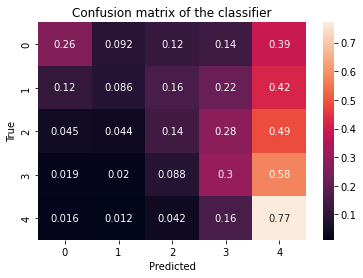

In [86]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [23]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)